## Ensembles

In [ ]:
import os
import gdown
import shutil
import numpy as np
import pandas as pd
import pathlib
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.utils import save_img, img_to_array, array_to_img, load_img, image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import register_keras_serializable
# from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import xgboost as xgb

In [ ]:
from data_processing_utils import show_dirs_len, prepocess_to_crop, separate_vignette_images, crop_and_save

from models_processing_utils import make_sructured_subset, make_balanced_sructured_subset, make_custom_sructured_subset,\
                                    augment_and_save, run_augmentation, run_selective_augmentation, add_files, sample_and_copy_files,\
                                    generate_model_version_name, binary_class_weights, binary_class_weights_2, initial_bias_calc, initial_bias_calc_2,\
                                    MetricsLogger, CustomCheckpoint, plot_scores, plot_loss, plot_confusion_matrix, fbeta_metric,\
                                    make_model, get_predictions_df, get_predictions_df2, show_predicted,\
                                    ModelEvaluating, ModelPredicting, ModelTraining,\
                                    scan_dataset, preprocess_image, split_by_class, stratified_dataset_from_directory


## Формування робочого датасету

Завантаження джерела

In [ ]:
# https://drive.google.com/file/d/1Wn-z5ozhs94Pfgrix70CiCcQGZdTXh3z/view?usp=sharing
file_id = "1Wn-z5ozhs94Pfgrix70CiCcQGZdTXh3z"
url = f"https://drive.google.com/uc?id={file_id}"
output = "2020_supplemented_cropped.zip"

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1Wn-z5ozhs94Pfgrix70CiCcQGZdTXh3z
From (redirected): https://drive.google.com/uc?id=1Wn-z5ozhs94Pfgrix70CiCcQGZdTXh3z&confirm=t&uuid=b26d1b5a-3f8b-4fb0-8e30-56ffdee8b156
To: /content/2020_supplemented_cropped.zip
100%|██████████| 1.59G/1.59G [00:31<00:00, 50.8MB/s]


'2020_supplemented_cropped.zip'

In [ ]:
!unzip -q 2020_supplemented_cropped.zip

In [ ]:
os.makedirs('2020_supplemented_cropped', exist_ok=True)
!mv /content/content/2020_supplemented/* /content/2020_supplemented_cropped/

In [ ]:
show_dirs_len(pathlib.Path("/content/2020_supplemented_cropped"))

.: 2
train: 2
train/melanoma: 5093
train/other: 32112
test: 2
test/melanoma: 1587
test/other: 10638


In [ ]:
# shutil.rmtree("/content/2020_supplemented_cropped")

In [ ]:
data_dir = pathlib.Path("/content/2020_supplemented_cropped")

Завантажити зображення з набору 2019 року з видаленими чорними краями в тренувальному наборі.

In [ ]:
# https://drive.google.com/file/d/1Qo98PZ2fsgsp-nEG6DW4XX5NtUb16xoi/view?usp=sharing
file_id = "1Qo98PZ2fsgsp-nEG6DW4XX5NtUb16xoi"
url = f"https://drive.google.com/uc?id={file_id}"
output = "2019_all_croppedtr.zip"

gdown.download(url, output, quiet=False)
!unzip -q 2019_all_croppedtr.zip

Downloading...
From (original): https://drive.google.com/uc?id=1Qo98PZ2fsgsp-nEG6DW4XX5NtUb16xoi
From (redirected): https://drive.google.com/uc?id=1Qo98PZ2fsgsp-nEG6DW4XX5NtUb16xoi&confirm=t&uuid=94ca40a8-7074-4743-a186-3d53ac35b5b3
To: /content/2019_all_croppedtr.zip
100%|██████████| 1.26G/1.26G [00:18<00:00, 69.1MB/s]


In [ ]:
show_dirs_len(pathlib.Path("/content/2019_all_croppedtr"))

.: 2
train: 2
train/melanoma: 4513
train/other: 20768
test: 2
test/melanoma: 1327
test/other: 6911


Об'єднати набори даних. В 2020 році, позитивний клас, вже присутні зображення 2019 року, тому доповнення тільки негативним класом.

In [ ]:
!mv /content/2019_all_croppedtr/train/other/* /content/2020_supplemented_cropped/train/other
!mv /content/2019_all_croppedtr/test/other/* /content/2020_supplemented_cropped/test/other

In [ ]:
show_dirs_len(data_dir)

.: 2
train: 2
train/melanoma: 5093
train/other: 52880
test: 2
test/melanoma: 1587
test/other: 17549


In [ ]:
# select in validation directory 40:60 proportion of classes
val_dir = data_dir / "validation"
train_dir = data_dir / "train"
num_melanoma = len(os.listdir(os.path.join(train_dir, "melanoma")))
num_other = len(os.listdir(os.path.join(train_dir, "other")))
k = num_melanoma/num_other if num_other > 0 else 1
print(f'Class proportion={k}')
rates_per_class = {
    "melanoma": 0.2,
    "other": 0.2*k*1.57
}
make_balanced_sructured_subset(train_dir, val_dir, 10, rates_per_class, copy=False)

Class proportion=0.09631240544629349


In [ ]:
show_dirs_len(data_dir)

.: 3
train: 2
train/melanoma: 4075
train/other: 51281
test: 2
test/melanoma: 1587
test/other: 17549
validation: 2
validation/melanoma: 1018
validation/other: 1599


### Набори окремих років

In [ ]:
# 2020 з melanoma 2019
# https://drive.google.com/file/d/1Wn-z5ozhs94Pfgrix70CiCcQGZdTXh3z/view?usp=sharing
file_id = "1Wn-z5ozhs94Pfgrix70CiCcQGZdTXh3z"
url = f"https://drive.google.com/uc?id={file_id}"
output = "2020_supplemented_cropped.zip"

gdown.download(url, output, quiet=False)

!unzip -q 2020_supplemented_cropped.zip

In [ ]:
# https://drive.google.com/file/d/1Qo98PZ2fsgsp-nEG6DW4XX5NtUb16xoi/view?usp=sharing
file_id = "1Qo98PZ2fsgsp-nEG6DW4XX5NtUb16xoi"
url = f"https://drive.google.com/uc?id={file_id}"
output = "2019_all_croppedtr.zip"

gdown.download(url, output, quiet=False)
!unzip -q 2019_all_croppedtr.zip

Downloading...
From (original): https://drive.google.com/uc?id=1Qo98PZ2fsgsp-nEG6DW4XX5NtUb16xoi
From (redirected): https://drive.google.com/uc?id=1Qo98PZ2fsgsp-nEG6DW4XX5NtUb16xoi&confirm=t&uuid=94ca40a8-7074-4743-a186-3d53ac35b5b3
To: /content/2019_all_croppedtr.zip
100%|██████████| 1.26G/1.26G [00:18<00:00, 69.1MB/s]


In [ ]:
# датасет prove_ai для доповнення валідаційних даних
# https://https://drive.google.com/file/d/1K2IrjUHuHl1Nn-t0aUMGXOvytSABf108/view?usp=sharing
file_id = "1K2IrjUHuHl1Nn-t0aUMGXOvytSABf108"
url = f"https://drive.google.com/uc?id={file_id}"
output = "prove_ai_split.zip"

gdown.download(url, output, quiet=False)
!unzip -q prove_ai_split.zip

Downloading...
From: https://drive.google.com/uc?id=1K2IrjUHuHl1Nn-t0aUMGXOvytSABf108
To: /content/prove_ai_split.zip
100%|██████████| 15.5M/15.5M [00:00<00:00, 39.0MB/s]


зі змішаного набору вилучити валідаційний набор та розділити по роках, з набору 2020 вилучити меланому 2019, отримати тільки 2020, тільки 2019 без валідаційних даних

In [ ]:
val_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/validation")
# validation_paths, validation_labels = scan_dataset(val_dir, class_names)


In [ ]:
folder1 = "путь/к/папке1"
folder2 = "путь/к/папке2"
destination_folder = "путь/к/папке3"

# Получаем списки файлов
files1 = set(os.listdir(folder1))
files2 = set(os.listdir(folder2))

# Находим пересечение файлов
common_files = files1.intersection(files2)

# Перемещаем совпавшие файлы из папки2 в папку3
for file_name in common_files:
    source_path = os.path.join(folder2, file_name)
    destination_path = os.path.join(destination_folder, file_name)
    shutil.move(source_path, destination_path)

print(f"Перемещено {len(common_files)} файлов.")

## Завантаження даних для навчання

In [ ]:
# весь cropped датасет без аугментації
# https://drive.google.com/file/d/1vIdcm_P_m5jJxWtidqct1iy4VfiJfO4Y/view?usp=sharing
file_id = "1vIdcm_P_m5jJxWtidqct1iy4VfiJfO4Y"
url = f"https://drive.google.com/uc?id={file_id}"
output = "full_ds_croppedtr_no_augm.zip"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1vIdcm_P_m5jJxWtidqct1iy4VfiJfO4Y
From (redirected): https://drive.google.com/uc?id=1vIdcm_P_m5jJxWtidqct1iy4VfiJfO4Y&confirm=t&uuid=8bc78f8b-f80f-49ba-be29-7c11f155021b
To: /content/full_ds_croppedtr_no_augm.zip
100%|██████████| 2.08G/2.08G [00:29<00:00, 71.5MB/s]


'full_ds_croppedtr_no_augm.zip'

In [ ]:
!unzip -q full_ds_croppedtr_no_augm.zip

In [ ]:
# датасет prove_ai для доповнення валідаційних даних
# https://https://drive.google.com/file/d/1K2IrjUHuHl1Nn-t0aUMGXOvytSABf108/view?usp=sharing
file_id = "1K2IrjUHuHl1Nn-t0aUMGXOvytSABf108"
url = f"https://drive.google.com/uc?id={file_id}"
output = "prove_ai_split.zip"

gdown.download(url, output, quiet=False)
!unzip -q prove_ai_split.zip

Downloading...
From: https://drive.google.com/uc?id=1K2IrjUHuHl1Nn-t0aUMGXOvytSABf108
To: /content/prove_ai_split.zip
100%|██████████| 15.5M/15.5M [00:00<00:00, 59.6MB/s]


In [ ]:
# додати валідаційні дані
source_dir = pathlib.Path("/content/prove_ai_split/validation/other")
dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/validation/other")
add_files(source_dir, dest_dir)
source_dir1 = pathlib.Path("/content/prove_ai_split/validation/melanoma")
dest_dir1 = pathlib.Path("/content/full_ds_croppedtr_no_augm/validation/melanoma")
add_files(source_dir1, dest_dir1)

In [ ]:
data_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm")
show_dirs_len(data_dir)

.: 3
test: 2
test/other: 17549
test/melanoma: 1587
validation: 2
validation/other: 2107
validation/melanoma: 1113
train: 2
train/other: 51281
train/melanoma: 4075


## Визначення параметрів для побудови моделі, розбиття датасету

In [ ]:
@register_keras_serializable()
class ConvDepthwiseConvBlock(layers.Layer):
    def __init__(self, filters, scale=1, kernel_size=3, strides=1, activation="silu", kernel_regularizer=None, name="ConvDeptConv", **kwargs):
        super().__init__(name=name, **kwargs)
        self.filters = filters
        self.scale = scale
        self.kernel_size = kernel_size
        self.strides = strides
        self.activation = keras.activations.get(activation)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

        self.conv1 = None
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.Activation(self.activation)

        self.dw_conv = None
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.Activation(self.activation)

        self.conv2 = None
        self.bn3 = layers.BatchNormalization()
        self.act3 = layers.Activation(self.activation)

    def build(self, input_shape):
        self.conv1 = layers.Conv2D(filters=self.filters*self.scale,
                                   kernel_size=self.kernel_size,
                                   strides=self.strides,
                                   padding="same",
                                   kernel_regularizer=self.kernel_regularizer)

        self.dw_conv = layers.DepthwiseConv2D(kernel_size=self.kernel_size,
                                              strides=1,
                                              padding="same",
                                              depthwise_regularizer=self.kernel_regularizer)

        self.conv2 = layers.Conv2D(filters=self.filters,
                                   kernel_size=self.kernel_size,
                                   strides=1, padding="same",
                                   kernel_regularizer=self.kernel_regularizer)
        super().build(input_shape)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.dw_conv(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.conv2(x)
        x = self.bn3(x)
        x = self.act3(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "scale": self.scale,
            "kernel_size": self.kernel_size,
            "strides": self.strides,
            "kernel_regularizer": keras.regularizers.serialize(self.kernel_regularizer),
        })
        return config

In [ ]:
@register_keras_serializable()
class CBAM(layers.Layer):
    def __init__(self, reduction_ratio=8,  kernel_size=7, name="cbam", kernel_regularizer=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.reduction_ratio = reduction_ratio
        self.kernel_size = kernel_size
        self.kernel_regularizer=keras.regularizers.get(kernel_regularizer)

    def build(self, input_shape):
        channel = input_shape[-1]

        # Channel Attention
        self.global_avg_pool = layers.GlobalAveragePooling2D() #squeeze in one vector (batch_size, channels), avg each feature map (channel) of all pixls
        self.global_max_pool = layers.GlobalMaxPooling2D()

        #multy-layers perceptron
        self.shared_mlp = tf.keras.Sequential([
            layers.Dense(channel // self.reduction_ratio, activation='relu', kernel_regularizer=self.kernel_regularizer),
            layers.Dense(channel, kernel_regularizer=self.kernel_regularizer)
        ])

        self.reshape = layers.Reshape((1, 1, channel))

        # Spatial Attention
        self.conv_spatial = layers.Conv2D(filters=1,
                                  kernel_size=self.kernel_size,
                                  strides=1,
                                  padding='same',
                                  activation='sigmoid',
                                  kernel_regularizer=self.kernel_regularizer)

    def call(self, inputs, return_attention=False):
        # Channel Attention
        avg_pool = self.global_avg_pool(inputs)
        max_pool = self.global_max_pool(inputs)

        avg_full_conn = self.shared_mlp(avg_pool)
        max_full_conn = self.shared_mlp(max_pool)

        channel_attention = tf.keras.activations.sigmoid(avg_full_conn + max_full_conn)
        channel_attention = self.reshape(channel_attention)
        x = inputs * channel_attention  # Broadcasted multiplication

        # Spatial Attention
        avg_pool_spatial = tf.reduce_mean(x, axis=-1, keepdims=True) # карта ознак (batch_size, height, width, 1), avg of all channels
        max_pool_spatial = tf.reduce_max(x, axis=-1, keepdims=True)
        spatial_attention = tf.concat([avg_pool_spatial, max_pool_spatial], axis=-1)

        spatial_attention = self.conv_spatial(spatial_attention)
        x = x * spatial_attention  # Element-wise multiplication

        if return_attention:
            return x, channel_attention, spatial_attention
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "reduction_ratio": self.reduction_ratio,
            "kernel_regularizer": keras.regularizers.serialize(self.kernel_regularizer),
            "kernel_size": self.kernel_size,
        })
        return config


In [ ]:
data_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm")
show_dirs_len(data_dir)

In [ ]:
IM_SIZE = 256
# BATCH_SIZE = 32
VERSION = generate_model_version_name()
MODEL_NAME = f"Ensemble_model_{VERSION}"

In [ ]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]

In [ ]:
from keras.applications.densenet import preprocess_input as preprocess_densenet
from keras.applications.efficientnet_v2 import preprocess_input as preprocess_efficientnet_v2
from keras.applications.resnet_v2 import preprocess_input as preprocess_resnet
from keras.applications.xception import preprocess_input as preprocess_xception

In [ ]:
model_path1 = '/content/ft-EfficientNetV2B0_04-23-10.keras'
model_path2 = '/content/ft-EfficientNetV2B0_04-29-19.keras'
model_path3 = '/content/ft-EfficientNetV2B0_04-12-10_last.keras'
model_path4 = '/content/ft-DenseNet121_05-05-17.keras'
model_path5= '/content/EfficientNetV2B0_05-24-11.keras'
model_path6= '/content/ft-Xception_05-20-16.keras'
model_path7= '/content/small-ft-ResNet50V2_04-05-14.keras'
model_path8 = '/content/Custom_CNN_05-11-17_.keras'

model_1 = keras.models.load_model(model_path1, custom_objects={"preprocess_input": preprocess_efficientnet_v2})
model_2 = keras.models.load_model(model_path2, custom_objects={"preprocess_input": preprocess_efficientnet_v2})
model_3 = keras.models.load_model(model_path3, custom_objects={"preprocess_input": preprocess_efficientnet_v2})
model_4 = keras.models.load_model(model_path4, custom_objects={"preprocess_input": preprocess_densenet})
model_5 = keras.models.load_model(model_path5, custom_objects={"preprocess_input": preprocess_efficientnet_v2})
model_6 = keras.models.load_model(model_path6, custom_objects={"preprocess_input": preprocess_xception})
model_7 = keras.models.load_model(model_path7, custom_objects={"preprocess_input": preprocess_resnet})
model_8 = keras.models.load_model(model_path8, custom_objects={"ConvDeptConv": ConvDepthwiseConvBlock, "cbam": CBAM})

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 202 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def create_val_ds(val_data_dir, class_names, batch_size, shuffle=False):
    val_ds = tf.keras.utils.image_dataset_from_directory(
            val_data_dir,
            image_size=(256, 256),
            class_names=class_names,
            shuffle=shuffle,
            batch_size=batch_size)
    return val_ds

In [ ]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# виведення матриці розбіжностей
def confMatrix(truth, pred):
    cmatrix = confusion_matrix(truth, pred)

    chars = ['TN','FP','FN','TP']
    percentages = [f'{p:.2%}' for p in cmatrix.flatten()/np.sum(cmatrix)]
    labels = [f'{char}\n{perc}' for char, perc in zip(chars,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cmatrix, annot=labels, fmt='', cmap='Blues')

#     sns.heatmap(cmatrixKNN, annot=True)
    plt.title('Confusion matrix')
    plt.xlabel('Перебачення')
    plt.ylabel('Дійсність')

def evaluate_meta_model(val_labels, meta_probs, meta_preds, model_name):
  auc_roc = roc_auc_score(val_labels, meta_probs)
  acc = accuracy_score(val_labels, meta_preds)
  prec = precision_score(val_labels, meta_preds)
  recall = recall_score(val_labels, meta_preds)
  bal_acc = balanced_accuracy_score(val_labels, meta_preds)
  f1 = f1_score(val_labels, meta_preds)
  prec_curve, recall_curve, _ = precision_recall_curve(val_labels, meta_probs)
  auc_prc = auc(recall_curve, prec_curve)

  print("Оцінки мета-моделі:")
  print(f"AUC: {auc_roc:.4f}")
  print(f"Accuracy: {acc:.4f}")
  print(f"Balanced accuracy: {bal_acc:.4f}")
  print(f"Precision: {prec:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1: {f1:.4f}")
  print(f"AUC-PRC: {auc_prc:.4f}")

  print(classification_report(val_labels, meta_preds))

  fp_rate, tp_rate, _ = roc_curve(val_labels, meta_probs)
  roc_auc = auc(fp_rate, tp_rate)

  plt.figure(figsize=(8, 6))
  plt.plot(fp_rate, tp_rate, label=f"ROC curve (AUC = {roc_auc:.2f})")
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"ROC Curve-{model_name}")
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
def create_test_ds(data_folder, image_size, batch_size):
  dataset = tf.keras.utils.image_dataset_from_directory(
  data_folder,
  label_mode=None,
  image_size=image_size,
  batch_size=batch_size,
  shuffle=False)
  return dataset


def get_predictions_df_metamodel(base_models, meta_model, data_folder, img_size=(256, 256), batch_size=32, threshold = 0.5, proba=True):

  dataset = create_test_ds(data_folder, img_size, batch_size)

    # get filenames, dataset.file_paths
  file_paths = dataset.file_paths

  # dataset.unbatch().batch(BATCH_SIZE)

  meta_features = np.hstack([model.predict(create_test_ds(data_folder, img_size, batch_size)) for model in base_models])
  if proba:
      meta_probs = meta_model.predict_proba(meta_features)[:, 1]
  else:
      meta_probs = meta_model.predict(meta_features).flatten()

  meta_preds = (meta_probs >= threshold).astype(int)

  true_labels = np.array([0 if 'other' in fp else 1 for fp in file_paths])

  predictions_df = pd.DataFrame({
      'file_path': file_paths,
      'true_label': true_labels,
      'predicted_label': meta_preds,
      'predicted_prob': meta_probs
  })
  return predictions_df

## Логістична регресія

### model_1, model_2, model_3

In [ ]:
val_data_dir = data_dir / "validation"
models = [model_1, model_2, model_3]

val_data = create_val_ds(val_data_dir, ["other", "melanoma"], 16)

file_paths = val_data.file_paths
# true_labels = np.concatenate([label.numpy() for path, label in val_data])
true_labels = np.array([0 if 'other' in fp else 1 for fp in file_paths])
# сбросити ітератор
# val_data.unbatch().batch(BATCH_SIZE)

meta_features = np.hstack([model.predict(create_val_ds(val_data_dir, ["other", "melanoma"], 16)) for model in models])
meta_model = LogisticRegression()

Found 3220 files belonging to 2 classes.
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step


In [ ]:
history = meta_model.fit(meta_features, true_labels)

### на навчальних даних

In [ ]:
meta_probs = meta_model.predict_proba(meta_features)[:, 1]
meta_preds = meta_model.predict(meta_features)
confMatrix(true_labels, meta_preds)
evaluate_meta_model(true_labels, meta_probs, meta_preds, MODEL_NAME)

In [ ]:
plot_confusion_matrix(true_labels, meta_preds, threshold=0.5)

### на тестових даних

In [ ]:
# predictions_df1 = get_predictions_df_metamodel([model_1, model_2, model_3], meta_model, dataset=test_dataset)
predictions_df1 = get_predictions_df_metamodel(models, meta_model, data_dir / "test", batch_size=16)

Found 19136 files.
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 65s 54ms/step


Оцінки мета-моделі:
AUC: 0.8941
Accuracy: 0.9147
Balanced accuracy: 0.7543
Precision: 0.4877
Recall: 0.5621
F1: 0.5222
AUC-PRC: 0.5469
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     17549
           1       0.49      0.56      0.52      1587

    accuracy                           0.91     19136
   macro avg       0.72      0.75      0.74     19136
weighted avg       0.92      0.91      0.92     19136



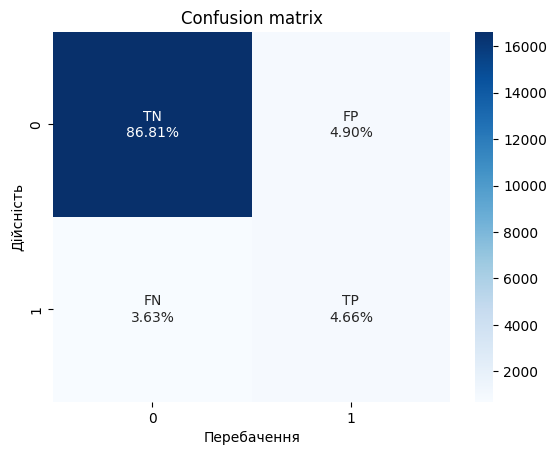

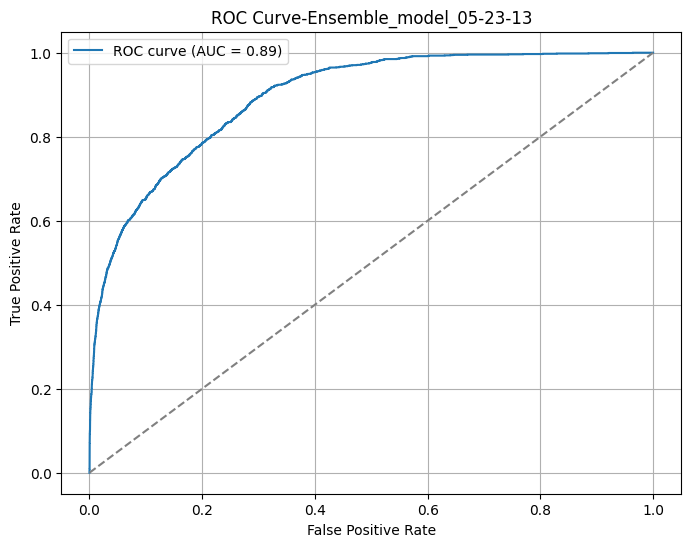

In [ ]:
confMatrix(predictions_df1['true_label'], predictions_df1['predicted_label'])
evaluate_meta_model(predictions_df1['true_label'], predictions_df1['predicted_prob'], predictions_df1['predicted_label'], MODEL_NAME)

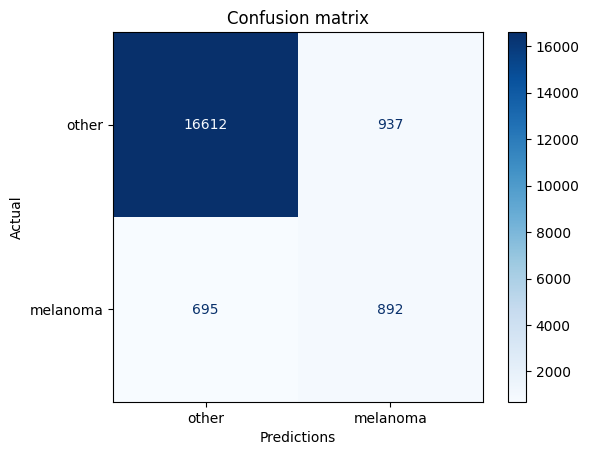

In [ ]:
plot_confusion_matrix(predictions_df1['true_label'], predictions_df1['predicted_label'], threshold=0.5)

In [ ]:
import joblib
joblib.dump(meta_model, 'meta_model_91.pkl')

['meta_model_91.pkl']

In [ ]:
meta_model = joblib.load('meta_model_91.pkl')

### на очищених тестових даних

In [ ]:
test_data_dir = pathlib.Path('/content/full_ds_croppedtr_no_augm/test')
prepocess_to_crop(test_data_dir)

With vignette /content/full_ds_croppedtr_no_augm/test/other: 2028
Without vignette /content/full_ds_croppedtr_no_augm/test/other: 15521
17549
With vignette /content/full_ds_croppedtr_no_augm/test/melanoma: 517
Without vignette /content/full_ds_croppedtr_no_augm/test/melanoma: 1070
1587


Found 19136 files.
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 64s 54ms/step
Оцінки мета-моделі:
AUC: 0.9117
Accuracy: 0.9130
Balanced accuracy: 0.7872
Precision: 0.4816
Recall: 0.6364
F1: 0.5483
AUC-PRC: 0.5823
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     17549
           1       0.48      0.64      0.55      1587

    accuracy                           0.91     19136
   macro avg       0.72      0.79      0.75     19136
weighted avg       0.93      0.91      0.92     19136



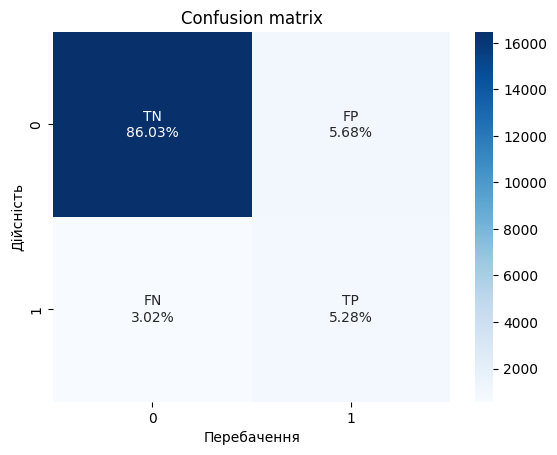

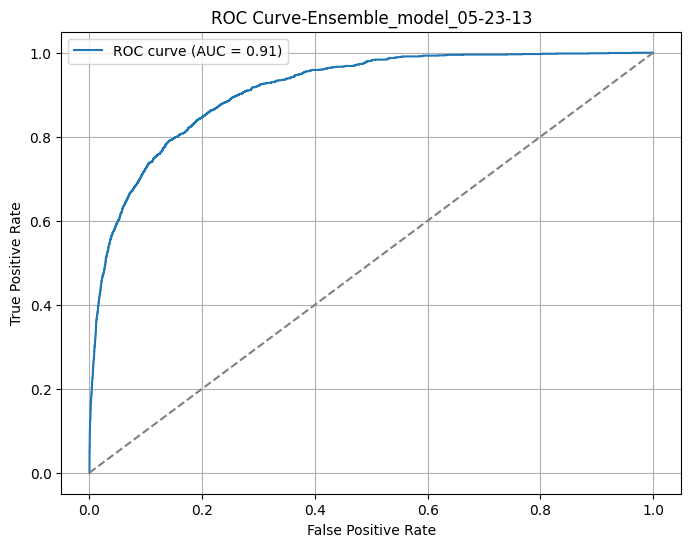

In [ ]:
predictions_df1 = get_predictions_df_metamodel(models, meta_model, data_dir / "test", batch_size=16)
confMatrix(predictions_df1['true_label'], predictions_df1['predicted_label'])
evaluate_meta_model(predictions_df1['true_label'], predictions_df1['predicted_prob'], predictions_df1['predicted_label'], MODEL_NAME)

### model_1, model_2, model_4

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
MODEL_NAME = f'Ensemble_model_{generate_model_version_name()}'
MODEL_NAME

'Ensemble_model_05-23-17'

In [ ]:
val_data_dir = data_dir / "validation"
models = [model_1, model_2, model_4]

val_data = create_val_ds(val_data_dir, ["other", "melanoma"], 16)

file_paths = val_data.file_paths
# true_labels = np.concatenate([label.numpy() for path, label in val_data])
true_labels = np.array([0 if 'other' in fp else 1 for fp in file_paths])

meta_features = np.hstack([model.predict(create_val_ds(val_data_dir, ["other", "melanoma"], 16)) for model in models])
meta_model = LogisticRegression()

history = meta_model.fit(meta_features, true_labels)

Found 3220 files belonging to 2 classes.
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step


### на тесті

Found 19136 files.
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 65s 54ms/step
Оцінки мета-моделі:
AUC: 0.7849
Accuracy: 0.9129
Balanced accuracy: 0.7849
Precision: 0.4808
Recall: 0.6314
F1: 0.5459
AUC-PRC: 0.5714
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     17549
           1       0.48      0.63      0.55      1587

    accuracy                           0.91     19136
   macro avg       0.72      0.78      0.75     19136
weighted avg       0.93      0.91      0.92     19136



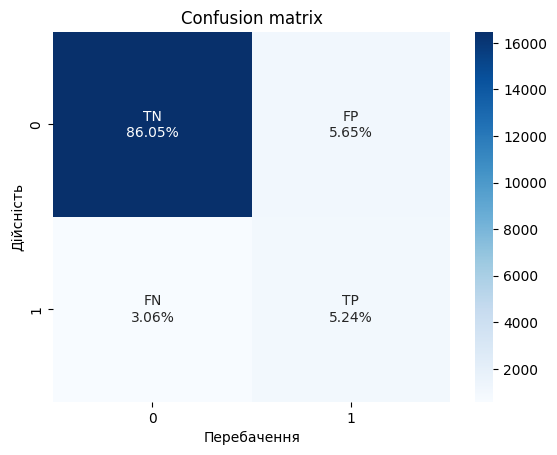

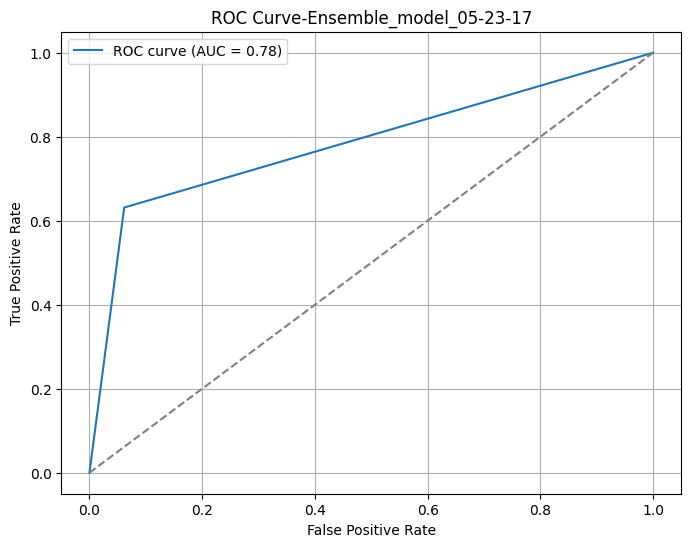

In [ ]:
predictions_df1 = get_predictions_df_metamodel(models, meta_model, data_dir / "test", batch_size=16, proba=False)
confMatrix(predictions_df1['true_label'], predictions_df1['predicted_label'])
evaluate_meta_model(predictions_df1['true_label'], predictions_df1['predicted_prob'], predictions_df1['predicted_label'], MODEL_NAME)

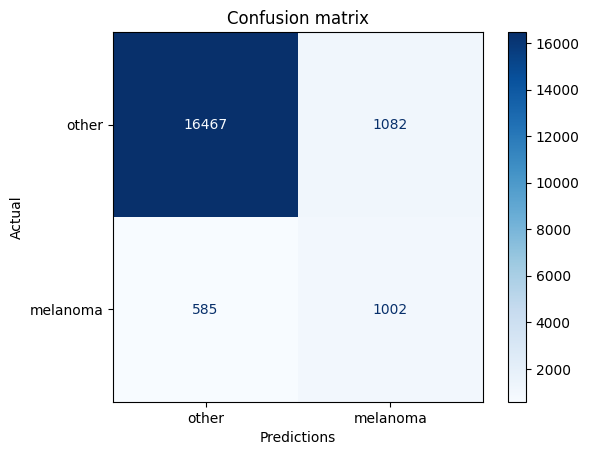

In [ ]:
plot_confusion_matrix(predictions_df1['true_label'], predictions_df1['predicted_label'], threshold=0.5)

model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
MODEL_NAME = f'Ensemble_model_{generate_model_version_name()}'
MODEL_NAME

'Ensemble_model_05-25-12'

In [ ]:
val_data_dir = data_dir / "validation"
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8 ]

val_data = create_val_ds(val_data_dir, ["other", "melanoma"], 16)

file_paths = val_data.file_paths
# true_labels = np.concatenate([label.numpy() for path, label in val_data])
true_labels = np.array([0 if 'other' in fp else 1 for fp in file_paths])

meta_features = np.hstack([model.predict(create_val_ds(val_data_dir, ["other", "melanoma"], 16)) for model in models])
meta_model = LogisticRegression()

history = meta_model.fit(meta_features, true_labels)

Found 3220 files belonging to 2 classes.
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


Found 19136 files.
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 63s 53ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 99s 83ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step
Оцінки мета-моделі:
AUC: 0.7884
Accuracy: 0.9062
Balanced accuracy: 0.7884
Precision: 0.4542
Recall: 0.6471
F1: 0.5338
AUC-PRC: 0.5653
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     17549
           1       0.45      0.65      0.53      1587

    accuracy                           0.91     19136
   macro avg       0.71      0.79      0.74     19136
weighted avg       0.92      0.91      0.91     19136



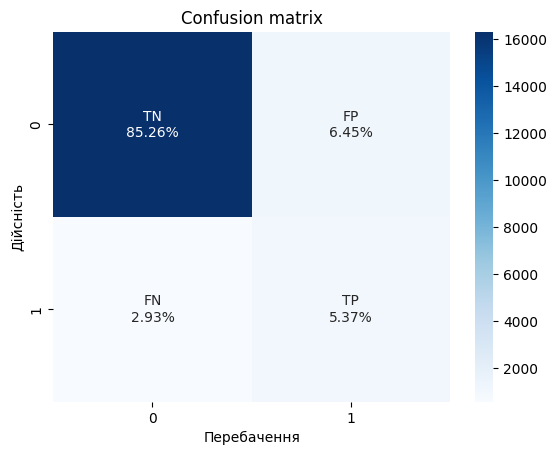

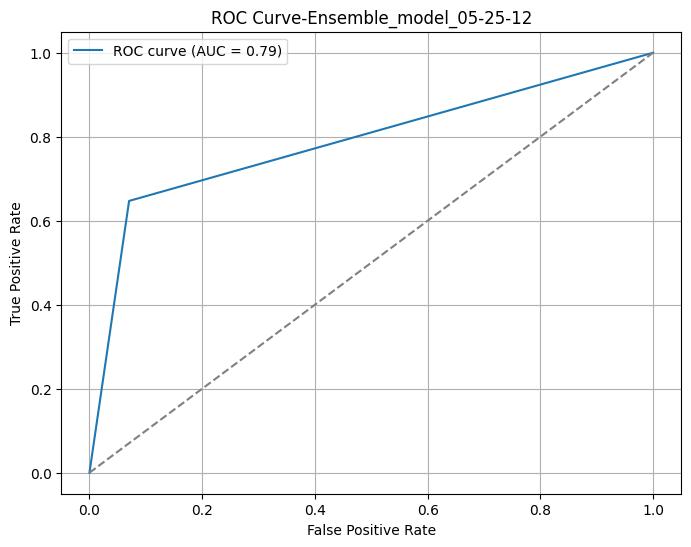

In [ ]:
predictions_df1 = get_predictions_df_metamodel(models, meta_model, data_dir / "test", batch_size=16, proba=False)
confMatrix(predictions_df1['true_label'], predictions_df1['predicted_label'])
evaluate_meta_model(predictions_df1['true_label'], predictions_df1['predicted_prob'], predictions_df1['predicted_label'], MODEL_NAME)

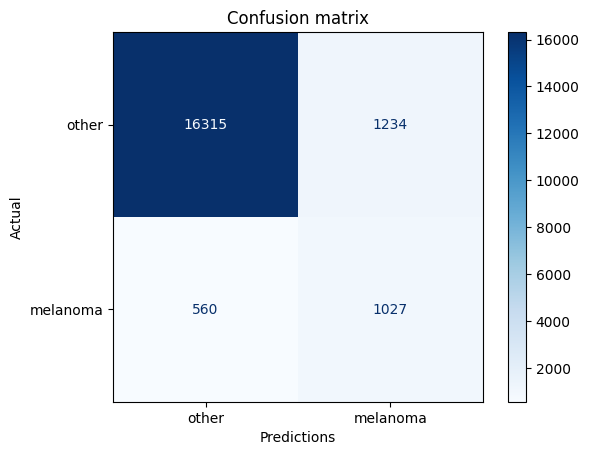

In [ ]:
plot_confusion_matrix(predictions_df1['true_label'], predictions_df1['predicted_label'], threshold=0.5)

## XGBClassifier

In [ ]:
import xgboost as xgb

In [ ]:
val_data_dir = data_dir / "validation"
models = [model_1, model_2, model_3]

val_data = create_val_ds(val_data_dir, ["other", "melanoma"], 16)

file_paths = val_data.file_paths
# true_labels = np.concatenate([label.numpy() for path, label in val_data])
true_labels = np.array([0 if 'other' in fp else 1 for fp in file_paths])

meta_features = np.hstack([model.predict(create_val_ds(val_data_dir, ["other", "melanoma"], 16)) for model in models])
meta_model2 = xgb.XGBClassifier(n_estimators=25, random_state=2, learning_rate=0.3, max_depth=3)

history = meta_model2.fit(meta_features, true_labels)

Found 3220 files belonging to 2 classes.
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step


Found 19136 files.
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 63s 52ms/step
Оцінки мета-моделі:
AUC: 0.7768
Accuracy: 0.9139
Balanced accuracy: 0.7768
Precision: 0.4850
Recall: 0.6125
F1: 0.5414
AUC-PRC: 0.5648
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     17549
           1       0.49      0.61      0.54      1587

    accuracy                           0.91     19136
   macro avg       0.72      0.78      0.75     19136
weighted avg       0.92      0.91      0.92     19136



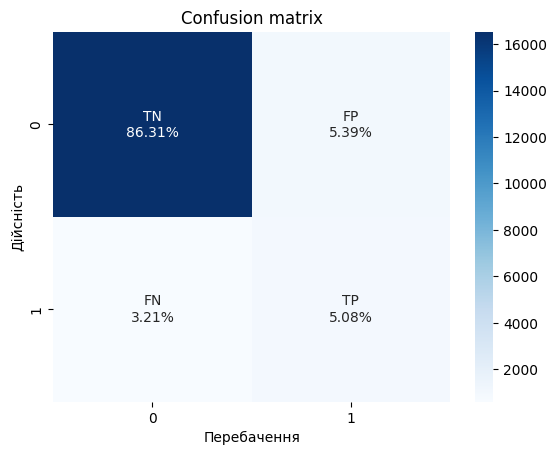

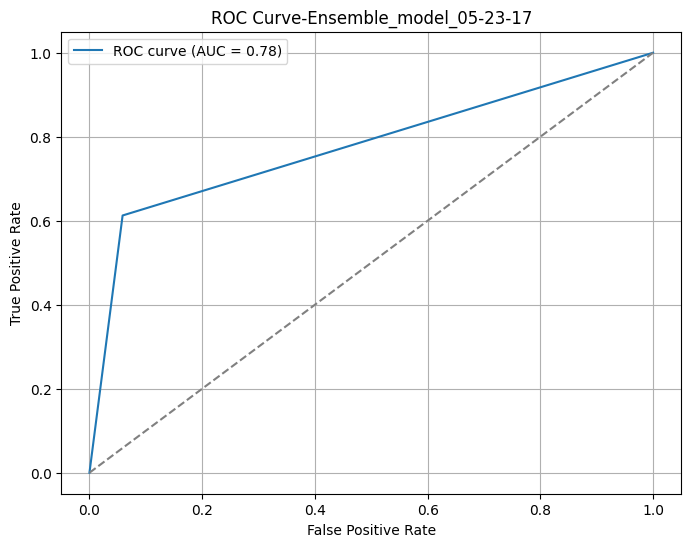

In [ ]:
predictions_df1 = get_predictions_df_metamodel(models, meta_model2, data_dir / "test", batch_size=16, proba=False)
confMatrix(predictions_df1['true_label'], predictions_df1['predicted_label'])
evaluate_meta_model(predictions_df1['true_label'], predictions_df1['predicted_prob'], predictions_df1['predicted_label'], MODEL_NAME)

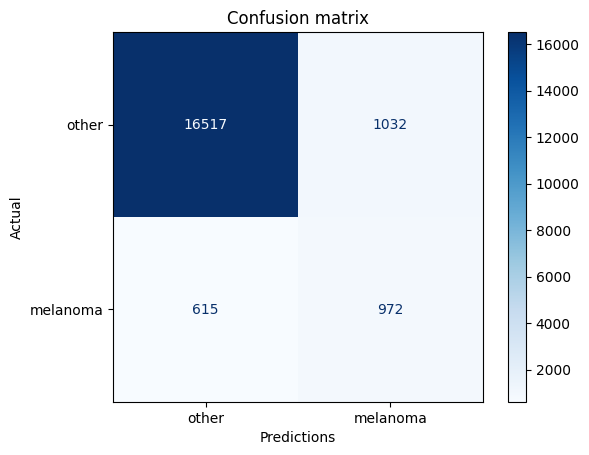

In [ ]:
plot_confusion_matrix(predictions_df1['true_label'], predictions_df1['predicted_label'], threshold=0.5)

## MLP

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
data_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm")
show_dirs_len(data_dir)

.: 3
test: 2
test/other: 17549
test/melanoma: 1587
validation: 2
validation/other: 2107
validation/melanoma: 1113
train: 2
train/other: 51281
train/melanoma: 4075


In [ ]:
val_data_dir = data_dir / "validation"
# models = [model_1, model_2, model_3]
# models = [model_1, model_2, model_4]
models = [model_1, model_2, model_3, model_4]

val_data = create_val_ds(val_data_dir, ["other", "melanoma"], 16)

file_paths = val_data.file_paths
# true_labels = np.concatenate([label.numpy() for path, label in val_data])
true_labels = np.array([0 if 'other' in fp else 1 for fp in file_paths])

meta_features = np.hstack([model.predict(create_val_ds(val_data_dir, ["other", "melanoma"], 16)) for model in models])

Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step


In [ ]:
meta_features.shape

(3220, 4)

In [ ]:
true_labels.shape

(3220,)

In [ ]:
from sklearn.utils import shuffle

meta_features_shuffled, true_labels_shuffled = shuffle(meta_features, true_labels, random_state=42)

In [ ]:
meta_model = keras.Sequential([
    layers.Input(shape=(meta_features.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

meta_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)
# callbacks_list = [EarlyStopping(monitor='val_auc', patience=3),
#                   ModelCheckpoint(f'ensemble_sequential.keras', monitor='val_loss', save_best_only=True)]


meta_model.fit(
    meta_features_shuffled, true_labels_shuffled,
    epochs=10,
    batch_size=8,
    validation_split=0.2,
    # callbacks=[keras.callbacks.EarlyStopping(monitor='val_auc', patience=4, restore_best_weights=True)]
)

results = meta_model.evaluate(meta_features, true_labels)

for metric, value in zip(["loss"] + [m.name for m in METRICS], results):
  print(metric, ': ', value)
print()

Epoch 1/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6922 - auc: 0.8045 - fn: 1351.4117 - fp: 21.1486 - loss: 0.5803 - prc: 0.6504 - precision: 0.8124 - recall: 0.1159 - tn: 2942.2075 - tp: 201.2074 - val_accuracy: 0.8602 - val_auc: 0.9150 - val_fn: 62.0000 - val_fp: 28.0000 - val_loss: 0.3765 - val_prc: 0.8785 - val_precision: 0.8534 - val_recall: 0.7244 - val_tn: 391.0000 - val_tp: 163.0000
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8664 - auc: 0.9199 - fn: 115.5975 - fp: 53.9257 - loss: 0.3367 - prc: 0.8969 - precision: 0.8591 - recall: 0.7398 - tn: 796.2817 - tp: 330.1703 - val_accuracy: 0.8696 - val_auc: 0.9218 - val_fn: 54.0000 - val_fp: 30.0000 - val_loss: 0.3369 - val_prc: 0.8866 - val_precision: 0.8507 - val_recall: 0.7600 - val_tn: 389.0000 - val_tp: 171.0000
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8659 - auc: 0.9119 - fn: 112.2322 - fp: 55.9969 - loss: 0.3296 - prc: 0.8811 - precision: 0.8407 - recall: 0.7367 - t

Found 19136 files.
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 34s 29ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 63s 53ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 64s 53ms/step
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Оцінки мета-моделі:
AUC: 0.9081
Accuracy: 0.9075
Balanced accuracy: 0.7905
Precision: 0.4591
Recall: 0.6503
F1: 0.5382
AUC-PRC: 0.5625
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     17549
           1       0.46      0.65      0.54      1587

    accuracy                           0.91     19136
   macro avg       0.71      0.79      0.74     19136
weighted avg       0.93      0.91      0.91     19136



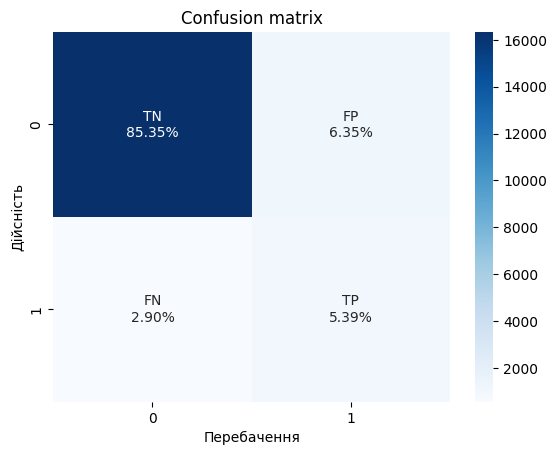

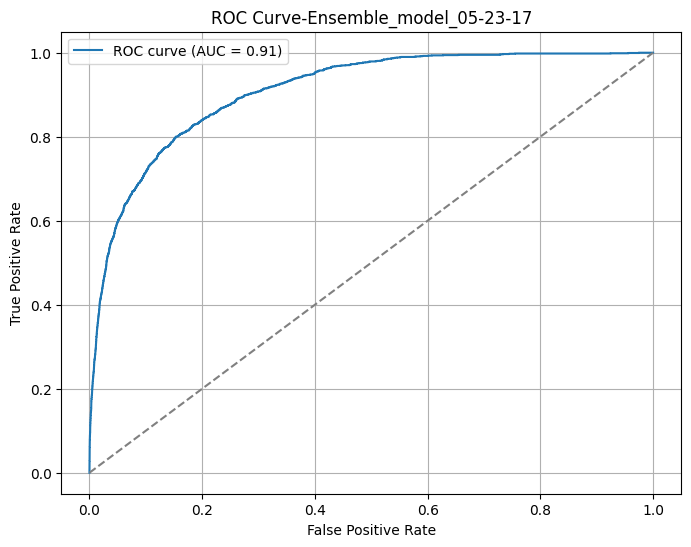

In [ ]:
predictions_df1 = get_predictions_df_metamodel(models, meta_model, data_dir / "test", batch_size=16, proba=False)
confMatrix(predictions_df1['true_label'], predictions_df1['predicted_label'])
evaluate_meta_model(predictions_df1['true_label'], predictions_df1['predicted_prob'], predictions_df1['predicted_label'], MODEL_NAME)

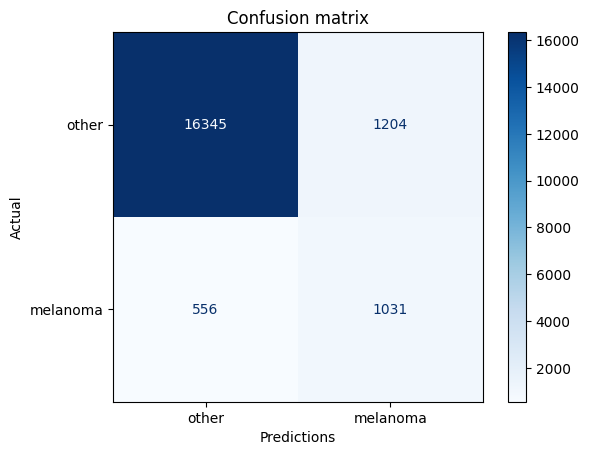

In [ ]:
plot_confusion_matrix(predictions_df1['true_label'], predictions_df1['predicted_label'], threshold=0.5)

In [ ]:
meta_model.save('meta_model_91.keras')

8 models, k-fold validation

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold

BATCH_SIZE = 16
val_data_dir = data_dir / "validation"
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8 ]

val_data = create_val_ds(val_data_dir, ["other", "melanoma"], BATCH_SIZE)
file_paths = val_data.file_paths

true_labels = np.array([0 if 'other' in fp else 1 for fp in file_paths])

meta_features = np.hstack([model.predict(create_val_ds(val_data_dir, ["other", "melanoma"], BATCH_SIZE)) for model in models])

meta_features_shuffled, true_labels_shuffled = shuffle(meta_features, true_labels, random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics = {'loss':[],
           'accuracy':[],
           'precision':[],
           'recall':[],
           'tp':[],
           'fp':[],
           'tn':[],
           'fn':[],
           'auc':[],
           'prc':[]
           }



Found 3220 files belonging to 2 classes.
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


In [ ]:
for fold, (train_index, val_index) in enumerate(kf.split(meta_features_shuffled, true_labels_shuffled), 1):
    X_train, X_val = meta_features_shuffled[train_index], meta_features_shuffled[val_index]
    y_train, y_val = true_labels_shuffled[train_index], true_labels_shuffled[val_index]

    meta_model = keras.Sequential([
        layers.Input(shape=(meta_features.shape[1],)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    meta_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    history = meta_model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        # verbose=0
    )


    eval_results = meta_model.evaluate(X_val, y_val, verbose=0)
    for metric, value in zip(["loss"] + [m.name for m in METRICS], eval_results):
        metrics[metric].append(value)

for metric, value in metrics.items():
  print(metric, ': ', value)
print()

print(f"Середні оцінки валідації:")
for metric in metrics.keys():
  print(f"Mean {metric}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")

Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.8048 - auc: 0.7740 - fn: 117.3951 - fp: 100.1790 - loss: 0.5891 - prc: 0.7608 - precision: 0.7248 - recall: 0.6647 - tn: 752.3210 - tp: 334.0062 - val_accuracy: 0.8680 - val_auc: 0.9277 - val_fn: 52.0000 - val_fp: 33.0000 - val_loss: 0.3220 - val_prc: 0.9058 - val_precision: 0.8374 - val_recall: 0.7658 - val_tn: 389.0000 - val_tp: 170.0000
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8860 - auc: 0.9331 - fn: 99.9938 - fp: 52.4198 - loss: 0.3031 - prc: 0.9155 - precision: 0.8822 - recall: 0.7883 - tn: 788.5062 - tp: 362.9815 - val_accuracy: 0.8758 - val_auc: 0.9345 - val_fn: 50.0000 - val_fp: 30.0000 - val_loss: 0.2966 - val_prc: 0.9117 - val_precision: 0.8515 - val_recall: 0.7748 - val_tn: 392.0000 - val_tp: 172.0000
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8694 - auc: 0.9318 - fn: 101.5864 - fp: 60.5556 - loss: 0.3077 - prc: 0.9016 - precision: 0.8486 - recall: 0.7565 - tn:

In [ ]:
# навчання після крос-валідації

meta_model = keras.Sequential([
    layers.Input(shape=(meta_features.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

meta_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)
history = meta_model.fit(
    meta_features_shuffled, true_labels_shuffled,
    epochs=30,
    batch_size=BATCH_SIZE,
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)],
)

Epoch 1/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8595 - auc: 0.9194 - fn: 292.1872 - fp: 391.9951 - loss: 0.5615 - prc: 0.8916 - precision: 0.7810 - recall: 0.8252 - tn: 2782.7981 - tp: 1384.8226
Epoch 2/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8815 - auc: 0.9339 - fn: 127.3941 - fp: 69.6946 - loss: 0.2933 - prc: 0.9141 - precision: 0.8592 - recall: 0.7805 - tn: 999.1035 - tp: 435.6108
Epoch 3/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8812 - auc: 0.9324 - fn: 122.6700 - fp: 72.0148 - loss: 0.2982 - prc: 0.9059 - precision: 0.8535 - recall: 0.7841 - tn: 1007.0640 - tp: 430.0542
Epoch 4/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8854 - auc: 0.9429 - fn: 114.8079 - fp: 73.1379 - loss: 0.2797 - prc: 0.9195 - precision: 0.8555 - recall: 0.8007 - tn: 1001.8670 - tp: 441.9901
Epoch 5/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8793 - auc: 0.9418 - fn: 123.1429 - fp: 75.1823 - loss: 0.2897 - prc: 0.9161 - precision:

Found 19136 files.
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 70s 100ms/step
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 98s 159ms/step
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 59s 93ms/step
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Оцінки мета-моделі:
AUC: 0.8842
Accuracy: 0.9102
Balanced accuracy: 0.7456
Precision: 0.4647
Recall: 0.5482
F1: 0.5030
AUC-PRC: 0.5192
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     17549
           1       0.46      0.55      0.50      1587

    accuracy                           0.91     19136
   macro avg       0.71      0.75      0.73     19136
weighted avg       0.92      0.91  

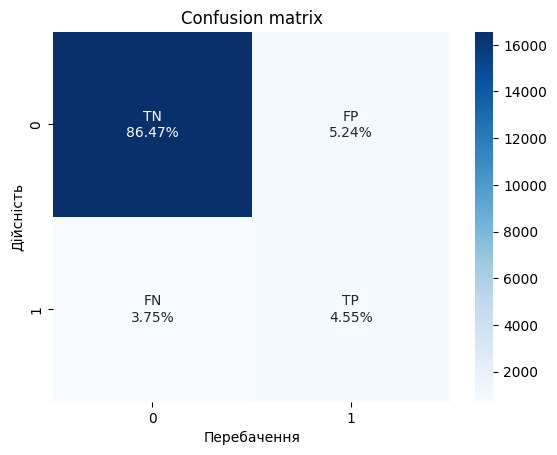

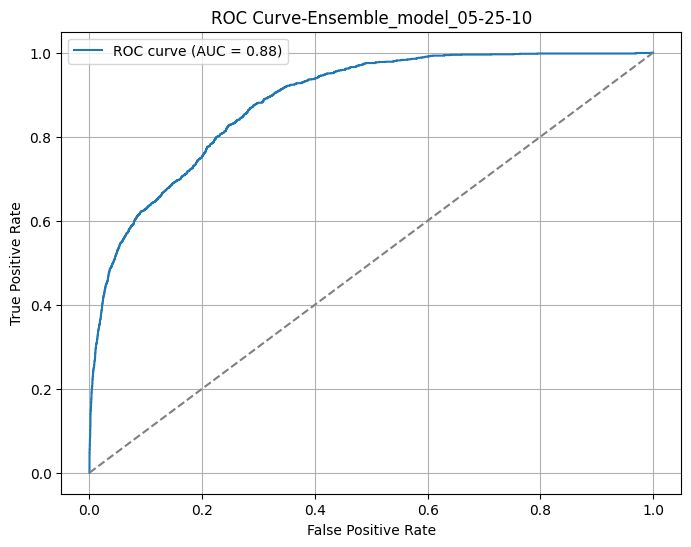

In [ ]:
predictions_df1 = get_predictions_df_metamodel(models, meta_model, data_dir / "test", batch_size=32, proba=False)
confMatrix(predictions_df1['true_label'], predictions_df1['predicted_label'])
evaluate_meta_model(predictions_df1['true_label'], predictions_df1['predicted_prob'], predictions_df1['predicted_label'], MODEL_NAME)

після очищення

Found 19136 files.
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 63s 102ms/step
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 94s 157ms/step
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 55s 90ms/step
Found 19136 files.
598/598 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Оцінки мета-моделі:
AUC: 0.8998
Accuracy: 0.9073
Balanced accuracy: 0.7795
Precision: 0.4572
Recall: 0.6263
F1: 0.5286
AUC-PRC: 0.5595
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     17549
           1       0.46      0.63      0.53      1587

    accuracy                           0.91     19136
   macro avg       0.71      0.78      0.74     19136
weighted avg       0.92      0.91  

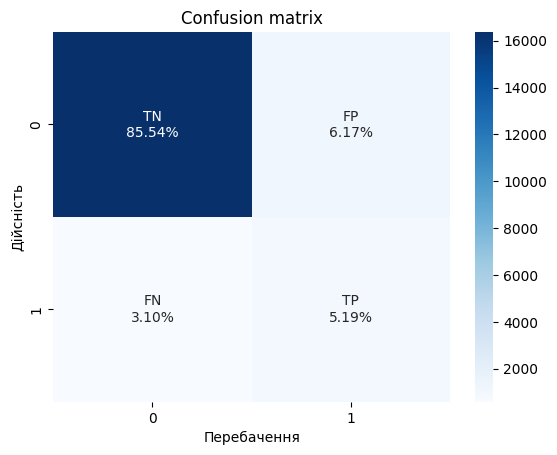

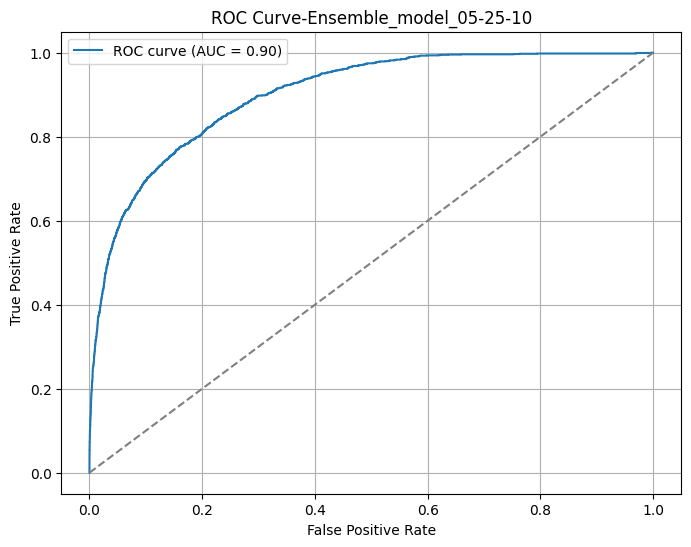

In [ ]:
predictions_df1 = get_predictions_df_metamodel(models, meta_model, data_dir / "test", batch_size=32, proba=False)
confMatrix(predictions_df1['true_label'], predictions_df1['predicted_label'])
evaluate_meta_model(predictions_df1['true_label'], predictions_df1['predicted_prob'], predictions_df1['predicted_label'], MODEL_NAME)

In [ ]:
# from sklearn.utils import shuffle
# from sklearn.model_selection import StratifiedKFold

BATCH_SIZE = 32
val_data_dir = data_dir / "validation"
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8 ]

val_data = create_val_ds(val_data_dir, ["other", "melanoma"], BATCH_SIZE)
file_paths = val_data.file_paths

true_labels = np.array([0 if 'other' in fp else 1 for fp in file_paths])

meta_features = np.hstack([model.predict(create_val_ds(val_data_dir, ["other", "melanoma"], BATCH_SIZE)) for model in models])

meta_features_shuffled, true_labels_shuffled = shuffle(meta_features, true_labels, random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics = {'loss':[],
           'accuracy':[],
           'precision':[],
           'recall':[],
           'tp':[],
           'fp':[],
           'tn':[],
           'fn':[],
           'auc':[],
           'prc':[]
           }



Found 3220 files belonging to 2 classes.
Found 3220 files belonging to 2 classes.
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step
Found 3220 files belonging to 2 classes.
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step
Found 3220 files belonging to 2 classes.
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step
Found 3220 files belonging to 2 classes.
101/101 ━━━━━━━━━━━━━━━━━━━━ 31s 190ms/step
Found 3220 files belonging to 2 classes.
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step
Found 3220 files belonging to 2 classes.
101/101 ━━━━━━━━━━━━━━━━━━━━ 29s 212ms/step
Found 3220 files belonging to 2 classes.
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step
Found 3220 files belonging to 2 classes.
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step


In [ ]:
for fold, (train_index, val_index) in enumerate(kf.split(meta_features_shuffled, true_labels_shuffled), 1):
    X_train, X_val = meta_features_shuffled[train_index], meta_features_shuffled[val_index]
    y_train, y_val = true_labels_shuffled[train_index], true_labels_shuffled[val_index]

    meta_model = keras.Sequential([
        layers.Input(shape=(meta_features.shape[1],)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    meta_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=METRICS)

    history = meta_model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        # verbose=0
    )


    eval_results = meta_model.evaluate(X_val, y_val, verbose=0)
    for metric, value in zip(["loss"] + [m.name for m in METRICS], eval_results):
        metrics[metric].append(value)

for metric, value in metrics.items():
  print(metric, ': ', value)
print()

print(f"Середні оцінки валідації:")
for metric in metrics.keys():
  print(f"Mean {metric}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8597 - auc: 0.8658 - fn: 154.4756 - fp: 128.7439 - loss: 0.6750 - prc: 0.8284 - precision: 0.8140 - recall: 0.7739 - tn: 1158.4269 - tp: 529.5732 - val_accuracy: 0.8121 - val_auc: 0.8846 - val_fn: 35.0000 - val_fp: 86.0000 - val_loss: 0.6624 - val_prc: 0.8643 - val_precision: 0.6850 - val_recall: 0.8423 - val_tn: 336.0000 - val_tp: 187.0000
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8260 - auc: 0.8985 - fn: 72.5976 - fp: 163.2195 - loss: 0.6549 - prc: 0.8763 - precision: 0.7177 - recall: 0.8369 - tn: 702.9025 - tp: 388.5000 - val_accuracy: 0.7966 - val_auc: 0.8973 - val_fn: 32.0000 - val_fp: 99.0000 - val_loss: 0.6416 - val_prc: 0.8733 - val_precision: 0.6574 - val_recall: 0.8559 - val_tn: 323.0000 - val_tp: 190.0000
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8229 - auc: 0.9228 - fn: 61.7073 - fp: 173.6463 - loss: 0.6294 - prc: 0.9034 - precision: 0.7020 - recall: 0.8733 - tn: 683

## GradientBoostingClassifier



model_1, model_2, model_5

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
val_data_dir = data_dir / "validation"
models = [model_1, model_2, model_5]

val_data = create_val_ds(val_data_dir, ["other", "melanoma"], 16)

file_paths = val_data.file_paths
# true_labels = np.concatenate([label.numpy() for path, label in val_data])
true_labels = np.array([0 if 'other' in fp else 1 for fp in file_paths])

meta_features = np.hstack([model.predict(create_val_ds(val_data_dir, ["other", "melanoma"], 16)) for model in models])
meta_model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
history = meta_model2.fit(meta_features, true_labels)

Found 3220 files belonging to 2 classes.
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step


Found 19136 files.
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step
Оцінки мета-моделі:
AUC: 0.8997
Accuracy: 0.8980
Balanced accuracy: 0.7845
Precision: 0.4249
Recall: 0.6484
F1: 0.5133
AUC-PRC: 0.5642
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     17549
           1       0.42      0.65      0.51      1587

    accuracy                           0.90     19136
   macro avg       0.70      0.78      0.73     19136
weighted avg       0.92      0.90      0.91     19136



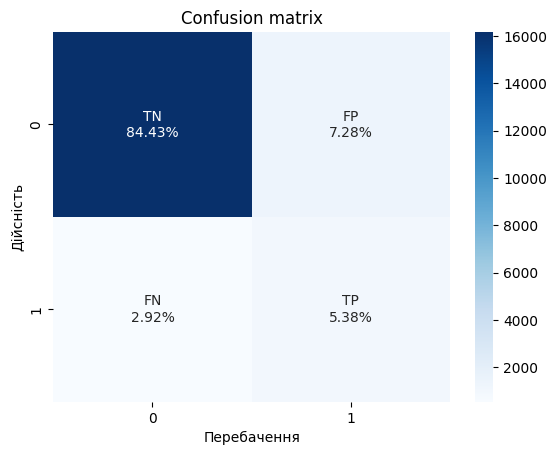

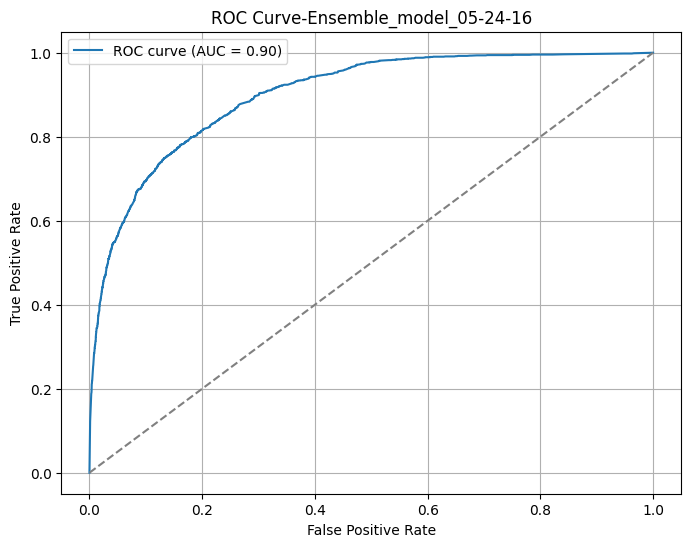

In [ ]:
predictions_df1 = get_predictions_df_metamodel(models, meta_model2, data_dir / "test", batch_size=16, proba=True)
confMatrix(predictions_df1['true_label'], predictions_df1['predicted_label'])
evaluate_meta_model(predictions_df1['true_label'], predictions_df1['predicted_prob'], predictions_df1['predicted_label'], MODEL_NAME)

model_1, model_2, model_3, model_4, model_5

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
val_data_dir = data_dir / "validation"
models = [model_1, model_2, model_3, model_4, model_5]

val_data = create_val_ds(val_data_dir, ["other", "melanoma"], 16)

file_paths = val_data.file_paths
# true_labels = np.concatenate([label.numpy() for path, label in val_data])
true_labels = np.array([0 if 'other' in fp else 1 for fp in file_paths])

meta_features = np.hstack([model.predict(create_val_ds(val_data_dir, ["other", "melanoma"], 16)) for model in models])
meta_model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
history = meta_model2.fit(meta_features, true_labels)

Found 3220 files belonging to 2 classes.
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step


Found 19136 files.
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 76s 56ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 68s 56ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step
Оцінки мета-моделі:
AUC: 0.9048
Accuracy: 0.9095
Balanced accuracy: 0.7776
Precision: 0.4659
Recall: 0.6194
F1: 0.5318
AUC-PRC: 0.5388
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     17549
           1       0.47      0.62      0.53      1587

    accuracy                           0.91     19136
   macro avg       0.72      0.78      0.74     19136
weighted avg       0.92      0.91      0.92     19136



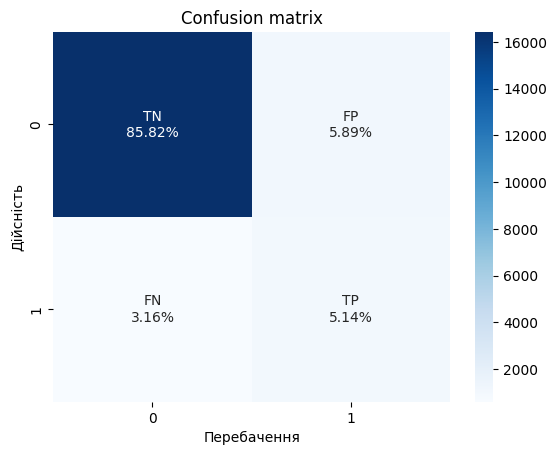

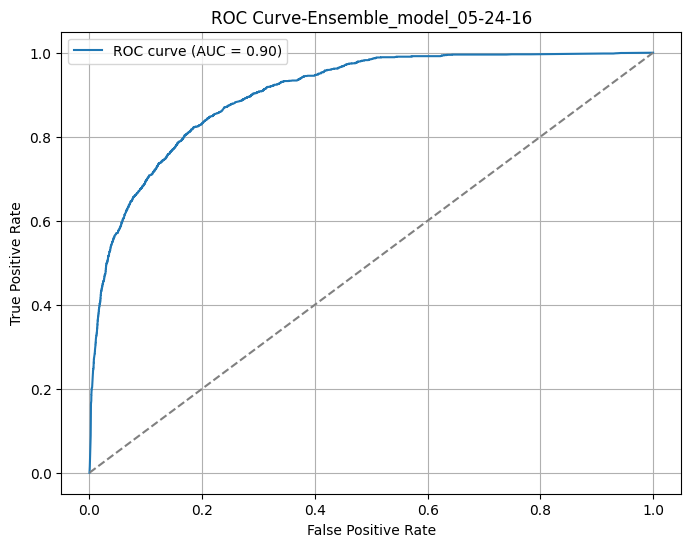

In [ ]:
predictions_df1 = get_predictions_df_metamodel(models, meta_model2, data_dir / "test", batch_size=16, proba=True)
confMatrix(predictions_df1['true_label'], predictions_df1['predicted_label'])
evaluate_meta_model(predictions_df1['true_label'], predictions_df1['predicted_prob'], predictions_df1['predicted_label'], MODEL_NAME)

model_1, model_2, model_4, model_5

In [ ]:
val_data_dir = data_dir / "validation"
models = [model_1, model_2, model_4, model_5]

val_data = create_val_ds(val_data_dir, ["other", "melanoma"], 16)

file_paths = val_data.file_paths
# true_labels = np.concatenate([label.numpy() for path, label in val_data])
true_labels = np.array([0 if 'other' in fp else 1 for fp in file_paths])

meta_features = np.hstack([model.predict(create_val_ds(val_data_dir, ["other", "melanoma"], 16)) for model in models])
meta_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
history = meta_model.fit(meta_features, true_labels)

Found 3220 files belonging to 2 classes.
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step
Found 3220 files belonging to 2 classes.
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step


In [ ]:
from sklearn.utils.validation import check_is_fitted

try:
    check_is_fitted(model)
except:
    print("Модель не обучена! Нужно вызвать fit()")

Модель не обучена! Нужно вызвать fit()


Found 19136 files.
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 69s 57ms/step
Found 19136 files.
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step
Оцінки мета-моделі:
AUC: 0.9047
Accuracy: 0.9087
Balanced accuracy: 0.7774
Precision: 0.4622
Recall: 0.6200
F1: 0.5296
AUC-PRC: 0.5456
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     17549
           1       0.46      0.62      0.53      1587

    accuracy                           0.91     19136
   macro avg       0.71      0.78      0.74     19136
weighted avg       0.92      0.91      0.91     19136



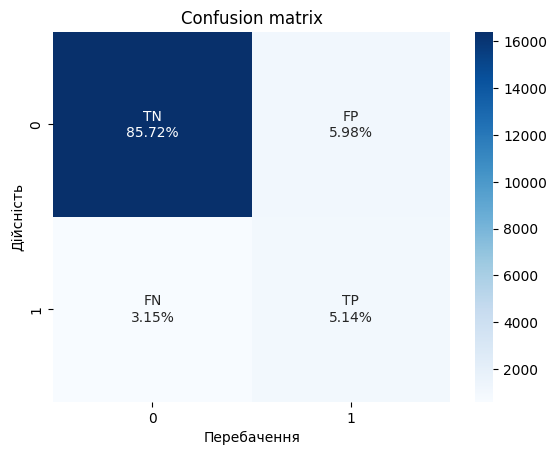

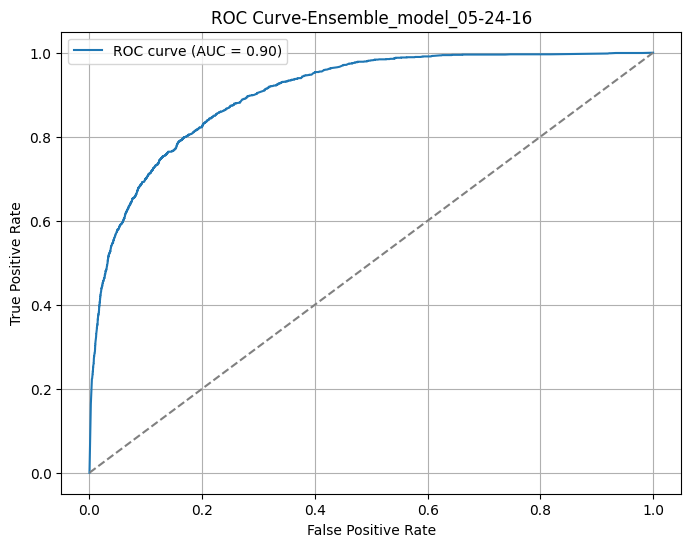

In [ ]:
predictions_df1 = get_predictions_df_metamodel(models, meta_model, data_dir / "test", batch_size=16, proba=True)
confMatrix(predictions_df1['true_label'], predictions_df1['predicted_label'])
evaluate_meta_model(predictions_df1['true_label'], predictions_df1['predicted_prob'], predictions_df1['predicted_label'], MODEL_NAME)

# Predictions

In [ ]:
predictions_df = predictions_df1

In [ ]:
mask_fp = (predictions_df['true_label'] == 0) & (predictions_df['predicted_label'] == 1)
mask_fn = (predictions_df['true_label'] == 1) & (predictions_df['predicted_label'] == 0)
mask_tn = (predictions_df['true_label'] == 0) & (predictions_df['predicted_label'] == 0)
mask_tp = (predictions_df['true_label'] == 1) & (predictions_df['predicted_label'] == 1)
fp_images_pathes = predictions_df.file_path[mask_fp]
fn_images_pathes = predictions_df.file_path[mask_fn]
tp_images_pathes = predictions_df.file_path[mask_tp]
tn_images_pathes = predictions_df.file_path[mask_tn]
print(f'FP: {len(fp_images_pathes)}, FN: {len(fn_images_pathes)}')
print(f'TP: {len(tp_images_pathes)}, TN: {len(tn_images_pathes)}')

FP: 1204, FN: 556
TP: 1031, TN: 16345


False Negative:


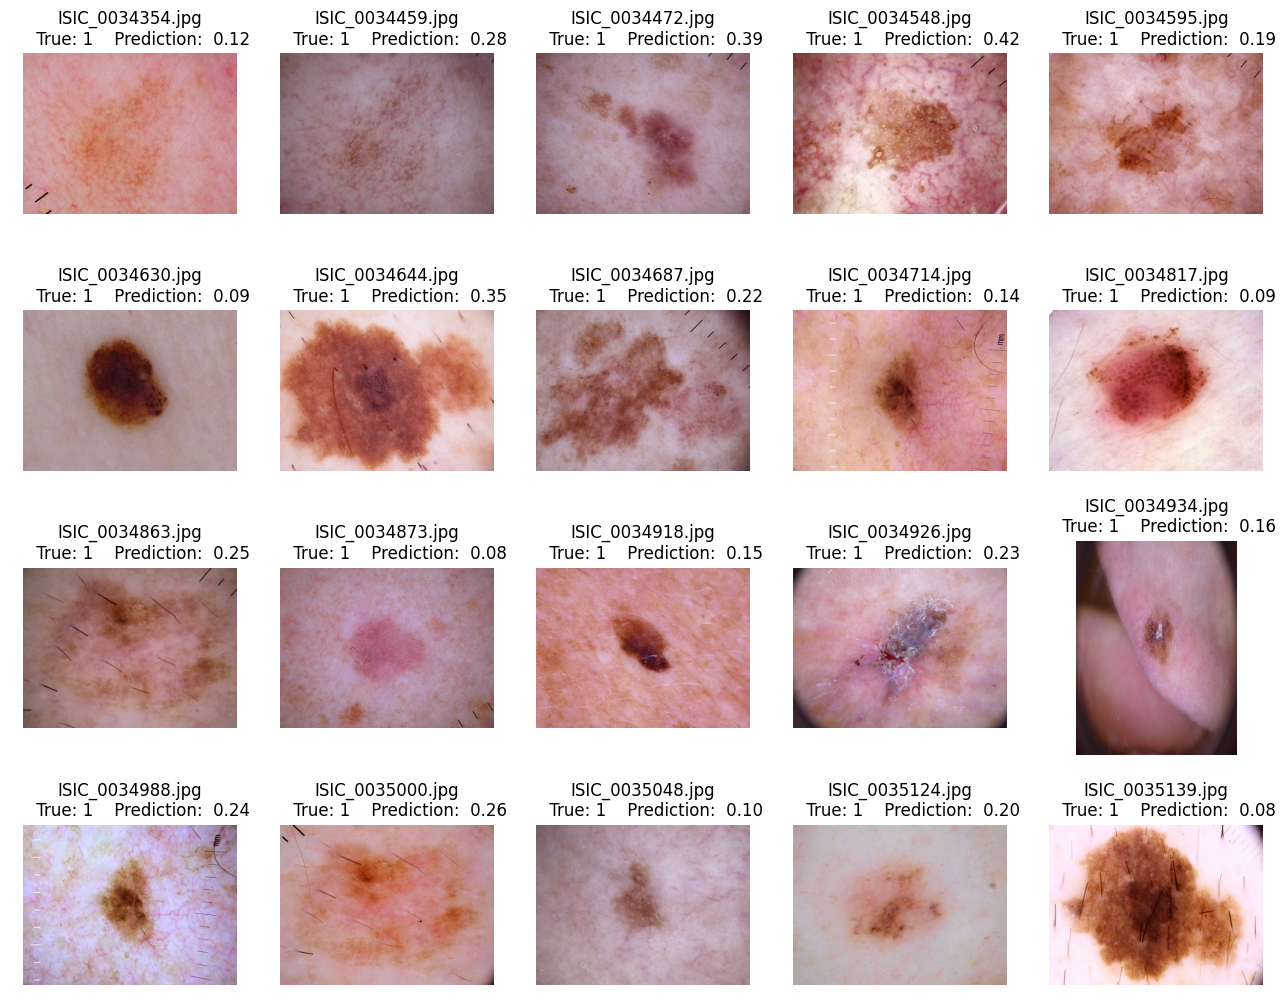

In [ ]:
# Візуалізація FN
print("False Negative:")
show_predicted(predictions_df, fn_images_pathes[:20])

False Positive:


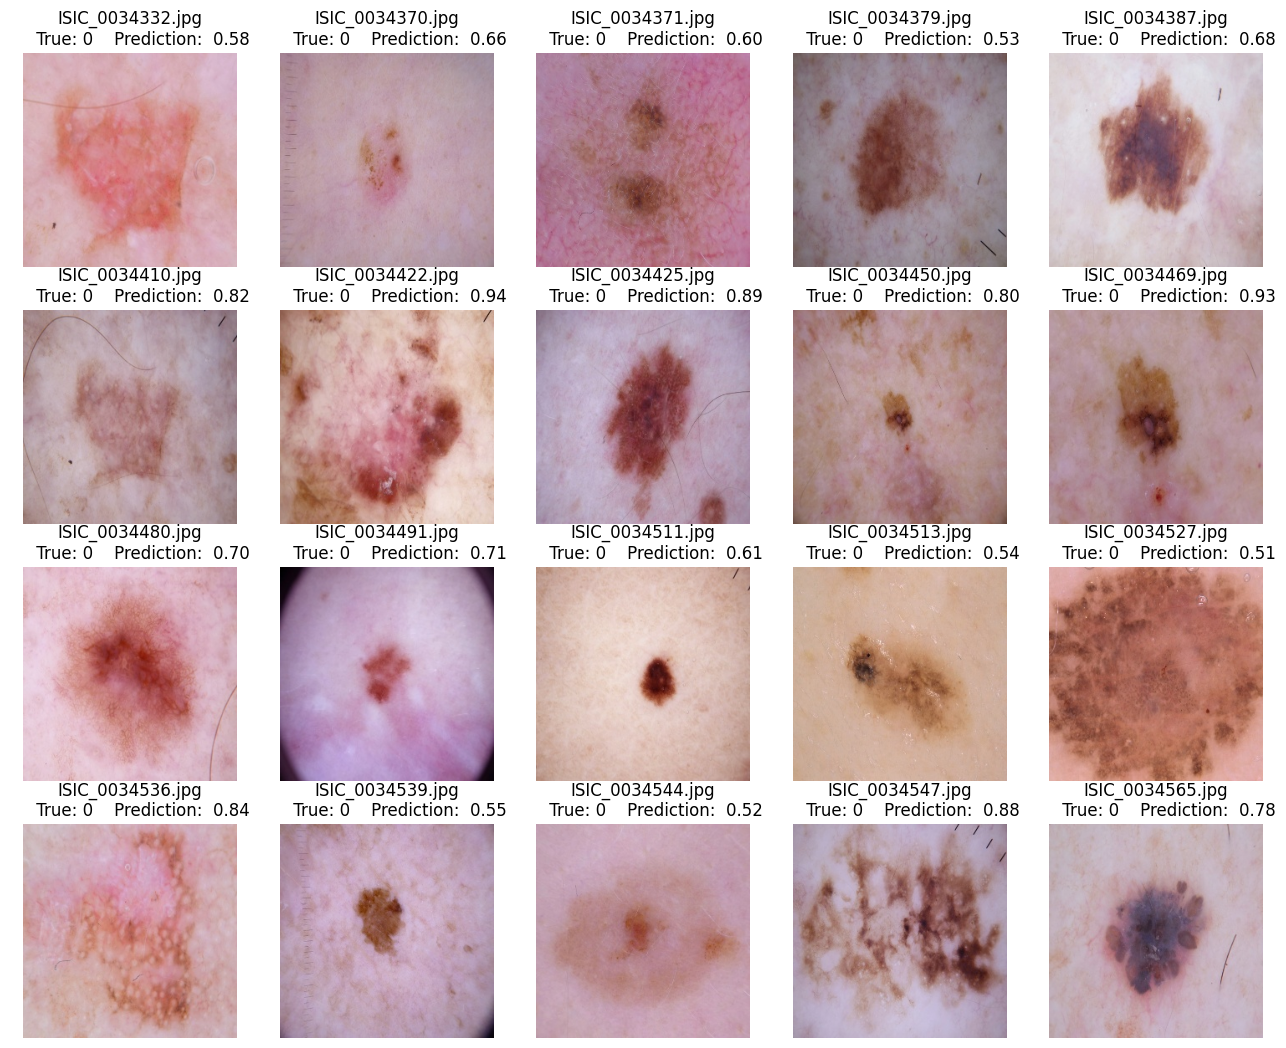

In [ ]:
# Візуалізація FP
print("False Positive:")
show_predicted(predictions_df, fp_images_pathes[:20])